# **Introduction**

In this tutorial, we will make use of the next-generation Pose Detection model from Google Research, which can detect up to 17 keypoints in the human body.

# MoveNet architecture in a nutshell

***How does it work ?***

MoveNet uses heatmaps to accurately localize human keypoints. It's a bottom-up estimation model, which means that it first detects the human joints of all persons, and then assemble these joints into poses for each person.[Source]

**Architecture (2 main components)**

**Feature extractor :** A MobileNetV2 with an attached feature pyramid network. Learn more about MobileNetV2

**A set of predictor heads :** attached to the feature extractor. They are responsible for predicting :
- the geometric center of the instances (persons)
- the full set of keypoints for a person
- the location of all the keypoints
- local offsets from each output feature map pixel to the precise sub-pixel location of each keypoint

https://blog.tensorflow.org/2021/05/next-generation-pose-detection-with-movenet-and-tensorflowjs.html

https://www.tensorflow.org/hub/tutorials/movenet



In [1]:
# Computer vision/graphics library
import cv2

# Gif writer
import imageio 

# Display libraries 
import matplotlib.pyplot as plt 
from IPython.display import HTML, display

# Calculations and Deep Learning library
import numpy as np 
import tensorflow as tf 
import tensorflow_hub as hub

In [2]:
! pip install -q git+https://github.com/tensorflow/docs

In [3]:
cyan = (255, 255, 0)
magenta = (255, 0, 255)

In [4]:
EDGE_COLORS = {
    (0, 1): magenta,
    (0, 2): cyan,
    (1, 3): magenta,
    (2, 4): cyan,
    (0, 5): magenta,
    (0, 6): cyan,
    (5, 7): magenta,
    (7, 9): cyan,
    (6, 8): magenta,
    (8, 10): cyan,
    (5, 6): magenta,
    (5, 11): cyan,
    (6, 12): magenta,
    (11, 12): cyan,
    (11, 13): magenta,
    (13, 15): cyan,
    (12, 14): magenta,
    (14, 16): cyan
}

Load the model from TF hub
Notes : MoveNet is offered with two variants, known as :

***Lightning :*** intended for latency-critical applications

***Thunder :*** for applications that require high accuracy


In [5]:
#model = hub.load("https://tfhub.dev/google/movenet/multipose/lightning/1")
model = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
movenet = model.signatures['serving_default']

Adjust the input size

According to the official documentation :
https://tfhub.dev/google/movenet/singlepose/thunder/4


In [14]:
width = height = 256

In [6]:
!wget -q -O dance.gif https://github.com/tensorflow/tfjs-models/raw/master/pose-detection/assets/dance_input.gif

In [7]:
def loop(frame, keypoints, threshold=0.11):
    # Loop through the results
    for instance in keypoints: 
        # Draw the keypoints and get the denormalized coordinates
        denormalized_coordinates = draw_keypoints(frame, instance, threshold)
        # Draw the edges
        draw_edges(denormalized_coordinates, frame, EDGE_COLORS, threshold)

In [27]:
def draw_keypoints(frame, keypoints, threshold=0.11):
    # Denormalize the coordinates : multiply the normalized coordinates by the input_size(width,height)
    denormalized_coordinates = np.squeeze(np.multiply(keypoints, [width,height,1]))
    #Iterate through the points
    for keypoint in denormalized_coordinates:
        # Unpack the keypoint values : y, x, confidence score
        keypoint_y, keypoint_x, keypoint_confidence = keypoint
        if keypoint_confidence > threshold:
            """"
            Draw the circle
            Note : A thickness of -1 px will fill the circle shape by the specified color.
            """
            cv2.circle(
                img=frame, 
                center=(int(keypoint_x), int(keypoint_y)), 
                radius=2, 
                color=(255,0,0),
                thickness=-1
            )
    return denormalized_coordinates

In [38]:
def draw_edges(denormalized_coordinates, frame, edges_colors, threshold=0.11):
    
    # Iterate throu
    for edge, color in edges_colors.items():
        # Get the dict value associated to the actual edge
        p1, p2 = edge
        # Get the points
        y1, x1, confidence_1 = denormalized_coordinates[p1]
        y2, x2, confidence_2 = denormalized_coordinates[p2]
        # Draw the line from point 1 to point 2, the confidence > threshold
        if (confidence_1 > threshold) & (confidence_2 > threshold):      
            cv2.line(
                img=frame, 
                pt1=(int(x1), int(y1)),
                pt2=(int(x2), int(y2)), 
                color=color, 
                thickness=1, 
                lineType=cv2.LINE_4 # Gives anti-aliased (smoothed) line which looks great for curves
            )

In [10]:
def progress(value, max=100):
    # Return an HTML progress bar 
    return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value,
                max=max))

In [11]:
def load_gif():
    # Load the gif
    gif = cv2.VideoCapture("./dance.gif")
    # Get the frame count
    frame_count = int(gif.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Frame count: {frame_count}")
    """""
    Initialize the video writer 
    We'll append each frame and its drawing to a vector, then stack all the frames to obtain a sequence (video). 
    """
    output_frames = []
    # Get the initial shape 
    initial_shape = []
    initial_shape.append(int(gif.get(cv2.CAP_PROP_FRAME_WIDTH)))
    initial_shape.append(int(gif.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    
    return gif, frame_count, output_frames, initial_shape

In [18]:
def run_inference():
    
    # Load the gif
    gif, frame_count, output_frames, initial_shape = load_gif()
    # Set the progress bar to 0. It ranges from the first to the last frame
    bar = display(progress(0, frame_count-1), display_id=True)
    
    while gif.isOpened():
        
        # Capture the frame
        ret, frame = gif.read()
        
        # Process the frame : resize to the input size
        if frame is None: 
            break
        
        # Retrieve the frame index
        index = gif.get(cv2.CAP_PROP_POS_FRAMES)
        
        # Copy the frame
        image = frame.copy()
        image = cv2.resize(image, (width,height))
        # Resize to the target shape and cast to an int32 vector
        input_image = tf.cast(tf.image.resize_with_pad(image, width, height), dtype=tf.int32)
        # Create a batch (input tensor)
        input_image = tf.expand_dims(input_image, axis=0)

        # Perform inference
        results = movenet(input_image)
       
        
        keypoints = results['output_0'].numpy()#[:,:,:51].reshape((6,17,3))

        # Loop through the results
        loop(image, keypoints, threshold=0.11)
        
        # Get the output frame : reshape to the original size
        frame_rgb = cv2.cvtColor(
            cv2.resize(
                image,(initial_shape[0], initial_shape[1]), 
                interpolation=cv2.INTER_LANCZOS4
            ), 
            cv2.COLOR_BGR2RGB # OpenCV processes BGR images instead of RGB
        ) 
        
        # Add the drawings to the output frames
        output_frames.append(frame_rgb)
        
        # Update the progress bar
        bar.update(progress(index, frame_count-1))
    
    # Release the object
    gif.release()
    
    return output_frames

In [39]:
output_frames = run_inference()

Frame count: 42


In [36]:
from tensorflow_docs.vis import embed


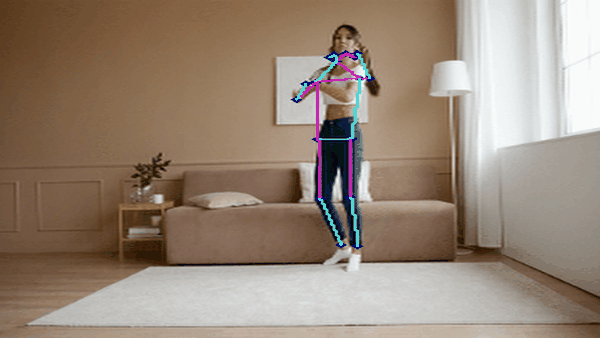

In [40]:
output = np.stack(output_frames, axis=0) # Stack the output frames to compose a sequence
imageio.mimsave("./animation.gif", output, fps=10) # Write the sequence to a gif
embed.embed_file('./animation.gif') # Embed the output to the notebook